# Imports

In [1]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Image

In [17]:
image_number = 11

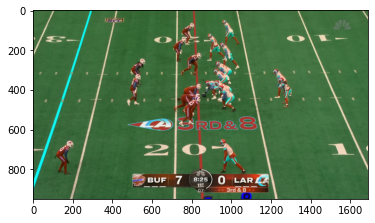

In [18]:
# load image as gray scale
img = cv2.imread(f"./pre_snap_images/test-data/{image_number}.png")
plt.imshow(img)

# Apply Transformations to Images

In [4]:
# gray scale the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# masking score bar
mask_height = int(gray.shape[0] * 0.81)
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.rectangle(mask, (0, 0), (gray.shape[1], mask_height), (255), thickness=-1)

# Apply the mask to the grayscale image
masked_gray = cv2.bitwise_and(gray, mask)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(masked_gray, (5, 5), 0)

# Edge detection
edged = cv2.Canny(blurred, 30, 150)

# Find contours
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def get_coord_function(x, y, w, h, buffer, img_h, img_w):
    x_0 = x
    if x_0 - buffer >= 0:
        x_0 -= buffer
        
    y_0 = y
    if y_0 - buffer >= 0:
        y_0 -= buffer
       
    x_1 = x + w
    if x_1 + buffer <= img_w:
        x_1 += buffer
        
    y_1 = y + h
    if y_1 + buffer <= img_h:
        y_1 += buffer

    return x_0, y_0, x_1, y_1

# Detect Contours

In [5]:
rm ./line_number_recognition/digit-*

In [6]:
# store contours
digits = list()
digit_map = dict()

# for more pixel info on image
buffer = 10

# for height threshold
img_h, img_w = edged.shape
max_height_threshold = img_h / 2.8
min_height_threshold = 30

print("h", " w", " i", "  j")

# Loop over the contours
for i, c in enumerate(contours):
    # Compute the bounding box for the contour then extract the digits
    (x, y, w, h) = cv2.boundingRect(c)
    if 110 >= h >= 10 and 110 >= w >= 40 and max_height_threshold >= y >= min_height_threshold :  # Filter based on typical number size and position
        x_0, y_0, x_1, y_1 = get_coord_function(x, y, w, h, buffer, img_h, img_w)

        digit = gray[y_0:y_1, x_0:x_1]
        digits.append(digit)

        print(h, w, i, len(digits) - 1)
        digit_map[f"digit-{i}.jpg"] = (x_0, y_0, x_1, y_1, w, h)
        
        if digit is not None and not digit.size == 0:
#             cv2.imwrite(f"./line_number_recognition/digit-{i}.jpg", digit)
            cv2.imwrite(f"./line_number_recognition/digit-{i}.jpg", cv2.resize(digit, (120, 120)))

print()
print(f"Max h thres: {max_height_threshold}")
print(f"Min h thres: {min_height_threshold}")
print(f"Length of candidate digits detected: {len(digits)}")

h  w  i   j
35 55 195 0
91 47 196 1
43 45 203 2
66 82 215 3
73 71 238 4
56 44 244 5
102 71 251 6
48 53 254 7
16 84 261 8
32 90 265 9
27 46 266 10
81 54 269 11
16 96 271 12
33 92 272 13
33 91 273 14
76 41 284 15

Max h thres: 339.28571428571433
Min h thres: 30
Length of candidate digits detected: 16


# Helper Functions

In [7]:
def read_sample_digits(digit):
    directory_path = f"./line_number_samples/{digit}"

    files = [cv2.imread(f"{directory_path}/{file}", 0) for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]
    return files

In [8]:
def match_digit(image, templates):
    matching_scores = {}

    for digit, temps in templates.items():
        for temp in temps:
            res = cv2.matchTemplate(image, temp, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            if digit not in matching_scores or max_val > matching_scores[digit]:
                matching_scores[digit] = max_val

    # Find the digit with the highest max matching score
    best_match = max(matching_scores, key=matching_scores.get)
    return best_match, matching_scores[best_match]

# Sample Digit Templates

In [9]:
# Load templates
templates = {
    '0': read_sample_digits('0'),
    '1': read_sample_digits('1'),
    '2': read_sample_digits('2'),
    '3': read_sample_digits('3'),
    '4': read_sample_digits('4'),
    '5': read_sample_digits('5')
}

# Matching

In [10]:
candidate_path = "./line_number_recognition/"
candidate_digits = [(cv2.imread(f"{candidate_path}/{file}", 0), file) for file in os.listdir(candidate_path) if os.path.isfile(os.path.join(candidate_path, file))]

In [11]:
digit_scores = list()

for digit_im, file_name in candidate_digits:
    flipped_image = cv2.flip(digit_im, -1)
    _, thresholded_image = cv2.threshold(flipped_image, 128, 255, cv2.THRESH_BINARY)

    digit, score = match_digit(thresholded_image, templates)
    if score >= .7:
        print(f"**File name:** {file_name} </br>")
        print(f"**Detected digit:** `{digit}` with a score of `{round(score, 3)}` </br>")
        print(f"**Answer: `{file_name.split('-')[-1]} -> TODO`**")
        print()
        
    digit_scores.append((digit, score, file_name))

**File name:** digit-265.jpg </br>
**Detected digit:** `0` with a score of `0.788` </br>
**Answer: `265.jpg -> TODO`**

**File name:** digit-273.jpg </br>
**Detected digit:** `1` with a score of `0.844` </br>
**Answer: `273.jpg -> TODO`**

**File name:** digit-272.jpg </br>
**Detected digit:** `0` with a score of `0.804` </br>
**Answer: `272.jpg -> TODO`**

**File name:** digit-266.jpg </br>
**Detected digit:** `3` with a score of `0.725` </br>
**Answer: `266.jpg -> TODO`**



# Showing Recognition on Original Image

Interesting notes:
- 0.7 or higher threshold is really solid for recognizing our yard marker digits
- 0.6 or higher is really good at finding rectanges for digits, but the numbers identified under the 0.7 threshold here are 50/50 for correctness
- we should be able to use 0.6 on for bounding digits, and 0.7 for recognizing digits
- we can also use 0.7 bounded rectangles to determine the heights of what other digits should be (roughly), this and being in the same "horizontal line" is useful for removing players that potentially sneak above the 0.6 threshold (i.e. if a jersey number is panned to the camera)
- in the same vein, a "vertical" line can be used for confirmation of a number below, or to get a second opinion if we only recognized the 0
- we can also use 0.7 as a strong idea of where yard lines should be (to distinguish them from l.o.s. and f.d.)


In [12]:
for _, score, file_name in digit_scores:
    if score >= .6:
        # Draw the rectangle around digit
        x_0, y_0, x_1, y_1, w, h = digit_map[file_name]
        bounded = cv2.rectangle(img, (x_0, y_0), (x_1, y_1), (0, 0, 255), 2)

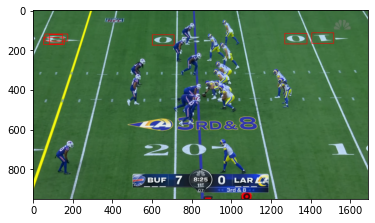

In [13]:
plt.imshow(cv2.cvtColor(bounded, cv2.COLOR_BGR2RGB))

In [14]:
sorted_digit_scores = sorted(digit_scores, key=lambda x: x[1], reverse=True)
sorted_digit_scores

[('1', 0.8438977599143982, 'digit-273.jpg'),
 ('0', 0.8035799264907837, 'digit-272.jpg'),
 ('0', 0.7878280878067017, 'digit-265.jpg'),
 ('3', 0.724545419216156, 'digit-266.jpg'),
 ('3', 0.6968934535980225, 'digit-271.jpg'),
 ('3', 0.6828673481941223, 'digit-261.jpg'),
 ('4', 0.5078208446502686, 'digit-284.jpg'),
 ('3', 0.48685601353645325, 'digit-195.jpg'),
 ('1', 0.3997723460197449, 'digit-254.jpg'),
 ('4', 0.395600825548172, 'digit-215.jpg'),
 ('4', 0.37742677330970764, 'digit-196.jpg'),
 ('2', 0.34256303310394287, 'digit-269.jpg'),
 ('2', 0.28430697321891785, 'digit-238.jpg'),
 ('4', 0.2720383405685425, 'digit-244.jpg'),
 ('0', 0.16773410141468048, 'digit-251.jpg'),
 ('5', 0.11408078670501709, 'digit-203.jpg')]